# Regression Model to Predict Total Count of Bees in a Given Month

### Model Building Process

The model building process consists of the following steps: 


- **Data Cleanup:** This involves examining the data for missing values and outliers, which were not present in this dataset. This can be done by looking at the summary statistics for the data, using the .info() and .describe() function calls on the data. The variable 'Year' is dropped from the analysis and it will not add much value to the model in terms of predictive power. 



- **Data Visualization + Feature Engineering:** The data is visualized to see any trends that can be noticed in the dataset. In this case, we can see that the bee count is much higher in the summer, spring and fall months when the temperature is warm, than in the winter months. Hence, a dummy variable "Spring_Summer_Fall" has been created to indicate times of peak bee count. 


- **Modelling:** A Test-Test-Test approach has been used here, where all variables which can potentially contribute to the model output have initially been included. This "test-down" approach starts with a complex model, with a large number of features and uses feature extraction techniques (outlined below) to hand-pick those features which are statistically significant.


- **Feature Extraction:** A heatmap is generated to visually show the pairwise correlation between different variables in the model. This helps choose which features to include and not to include in the modelling step. Different sets of features are included in the model and the p-value of the individual t-tests is checked from the OLS output. Variables which have a p-value greater than the chosen alpha of 0.05 are removed.


- **Heteroskedasticity Checks:** The model is checked to see if there is heteroskedasticity in the final output, by plotting the residuals against the fitted values and see if a cone-shape pattern emerges. 


- **Outlier Checks:** The Cook's distance plot is plotted to see if there are data points with high influence on the regression results. If there are such data points, then the outliers have to be either deleted if out-of-scope for the analysis, or imputed if in-scope.  

In [303]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.formula.api import ols
import seaborn as sns
from scipy.stats import norm
import statsmodels.api as sm

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from numpy import sqrt

In [304]:
data_1 = pd.read_excel('/Users/mohammadananjaved/Desktop/MMA860 - Data Acquisition & Management/MMA860_Exam_Data_2024B.xlsx',
                         sheet_name = 'Bees')

In [305]:
data_1.describe()

,Bee_Count,Year,Avg_Temp,Low_Temp,High_Temp,Total_Precip,Major_Storm,Avg_Wind_Speed,Avail_Flower_Species
count,54.000000,54.000000,54.000000,54.000000,54.000000,54.000000,54.000000,54.000000,54.000000
mean,34789.388889,2019.777778,11.907407,1.703704,22.111111,30.251852,0.462963,10.688889,14.685185
std,25047.689838,1.327029,13.105189,13.539083,13.481877,8.173467,0.573403,2.753911,10.912731
min,972.000000,2018.000000,-10.000000,-21.000000,-3.000000,13.600000,-1.000000,5.100000,0.000000
25%,6932.250000,2019.000000,0.750000,-10.000000,11.000000,24.800000,0.000000,8.925000,0.000000
50%,36958.000000,2020.000000,9.000000,1.000000,20.500000,29.450000,0.500000,10.600000,19.000000
75%,55907.750000,2021.000000,24.000000,15.000000,33.000000,35.150000,1.000000,12.500000,23.000000
max,77895.000000,2022.000000,32.000000,25.000000,46.000000,54.400000,1.000000,19.200000,30.000000


In [306]:
data_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54 entries, 0 to 53
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Bee_Count             54 non-null     int64  
 1   Year                  54 non-null     int64  
 2   Month                 54 non-null     object 
 3   Avg_Temp              54 non-null     int64  
 4   Low_Temp              54 non-null     int64  
 5   High_Temp             54 non-null     int64  
 6   Total_Precip          54 non-null     float64
 7   Major_Storm           54 non-null     int64  
 8   Avg_Wind_Speed        54 non-null     float64
 9   Avail_Flower_Species  54 non-null     int64  
dtypes: float64(2), int64(7), object(1)
memory usage: 4.3+ KB


In [307]:
data_1.head()

,Bee_Count,Year,Month,Avg_Temp,Low_Temp,High_Temp,Total_Precip,Major_Storm,Avg_Wind_Speed,Avail_Flower_Species
0,49926,2022,Jun,24,20,39,31.9,1,6.8,22
1,57750,2022,May,20,12,33,22.9,0,13.0,19
2,32164,2022,Apr,8,6,18,54.4,0,14.1,23
3,37344,2022,Mar,3,1,18,40.7,1,14.0,24
4,2385,2022,Feb,-8,-21,2,33.8,0,5.1,0


#### Dropping variables not needed - The calendar year would not have predictive capability for a natural phenomenon, such as, Bee Count

In [358]:
data_1.drop('Year', axis = 1, inplace = True)

#### Bar graph to identify a pattern in average bee count per month

In [359]:
data_1['Numeric_Month'] = data_1['Month'].map({'Jan':1, 'Feb':2, 'Mar':3, 'Apr':4, 'May':5, 'Jun':6, 'Jul':7, 'Aug':8,
                                    'Sep':9, 'Oct':10, 'Nov':11, 'Dec':12})

In [360]:
bee_count_monthly = data_1.groupby(['Month', 'Numeric_Month'], as_index = False)['Bee_Count'].mean().sort_values(by = 'Numeric_Month', ascending = True)

In [361]:
bee_count_monthly.rename(columns = {'Bee_Count': 'Average_Bee_Count'}, inplace = True)

In [362]:
bee_count_monthly.head()

,Month,Numeric_Month,Average_Bee_Count
4,Jan,1,3233.2
3,Feb,2,4269.2
7,Mar,3,32664.8
0,Apr,4,30393.6
8,May,5,50465.0


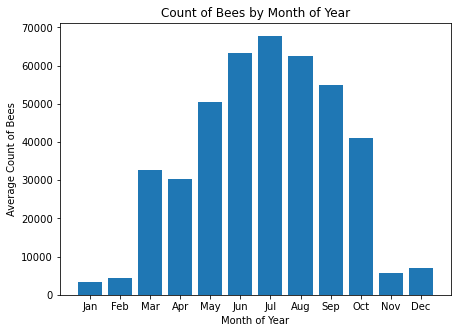

In [363]:
plt.figure(figsize = (7,5))
plt.bar(bee_count_monthly['Month'], bee_count_monthly['Average_Bee_Count'])
plt.xlabel('Month of Year')
plt.ylabel('Average Count of Bees')
plt.title('Count of Bees by Month of Year')
plt.show()

Since there is a spike in bee count from March - Oct, a dummy variable can be created to indicate the warm months Spring + Summer + Fall with a value of 1 and 0 to indicate Winter (Nov - Feb)

#### Creating a Dummy Variable "Spring_Summer_Fall" which groups the warm months as 1 and cold months as 0, based on trend seen above

In [364]:
data_1['Spring_Summer_Fall'] = data_1['Month'].map({'Apr':1, 'Aug':1, 'Jul':1, 'Jun':1, 'Mar':1, 'May':1, 'Oct':1, 'Sep':1,
                                            'Dec':0, 'Feb':0, 'Jan':0, 'Nov':0})

In [365]:
data_1[['Month','Spring_Summer_Fall']].drop_duplicates()

,Month,Spring_Summer_Fall
0,Jun,1
1,May,1
2,Apr,1
3,Mar,1
4,Feb,0
5,Jan,0
6,Dec,0
7,Nov,0
8,Oct,1
9,Sep,1


A heatmap is being generated to visually see the correlation between the different data points available to us.

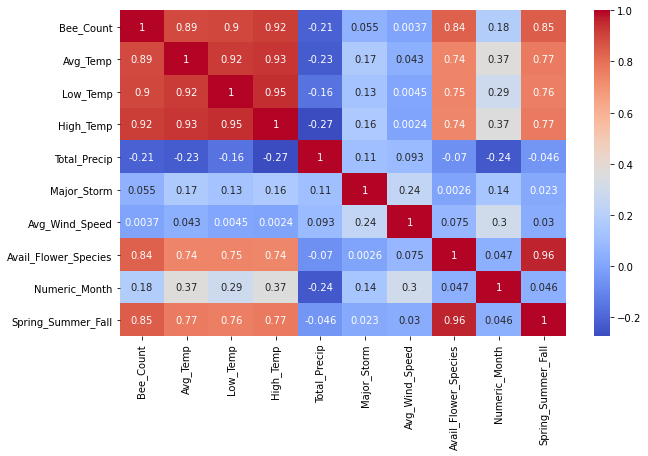

In [366]:
plt.figure(figsize=(10, 6))
heatmap = sns.heatmap(data_1.corr(), annot=True, cmap='coolwarm')

#### A top down approach is taken - Different combinations of features are checked and only features with a p-value of < 0.05, are chosen for the final model, given the correlations seen in the heatmap above

In [400]:
# Building a model with all possible variables in a TTT "top-down" approach

# model_1 = ols('Bee_Count ~ Avg_Temp + Low_Temp + High_Temp + Total_Precip + Major_Storm + Avg_Wind_Speed + Avail_Flower_Species + Spring_Summer_Fall', data_1).fit()
# model_1.summary()

#### Final Model Output

In [401]:
model_2 = ols('Bee_Count ~ Spring_Summer_Fall + Low_Temp + Total_Precip', data_1).fit()
model_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              Bee_Count   R-squared:                       0.883
Model:                            OLS   Adj. R-squared:                  0.876
Method:                 Least Squares   F-statistic:                     125.5
Date:                Sat, 15 Apr 2023   Prob (F-statistic):           2.88e-23
Time:                        13:35:03   Log-Likelihood:                -565.18
No. Observations:                  54   AIC:                             1138.
Df Residuals:                      50   BIC:                             1146.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept           2.787e+04   5102.515      5.461      0.000    1.76e+04    3.81e+04
Spring_Summer_Fall  2.187e+04   3952.931      5.534      0.000    1.39e+04    2.98e+04
Low_Temp            1046.4408    140.577      7.444      0.000     764.084    1328.798
Total_Precip        -312.1050    151.366     -2.062      0.044    -616.132      -8.078
==============================================================================
Omnibus:                        0.057   Durbin-Watson:                   1.718
Prob(Omnibus):                  0.972   Jarque-Bera (JB):                0.207
Skew:                           0.063   Prob(JB):                        0.902
Kurtosis:                       2.724   Cond. No.                         143.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Final Model

#### The final model is Bee_Count = 27870 + 21870 * Spring_Summer_Fall - 312.1050 * Total_Precip + 1046.4408 * Low_Temp

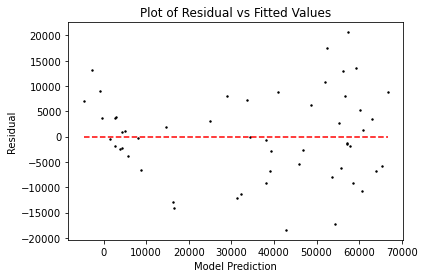

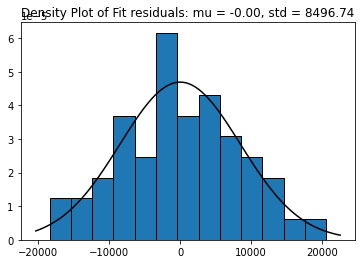

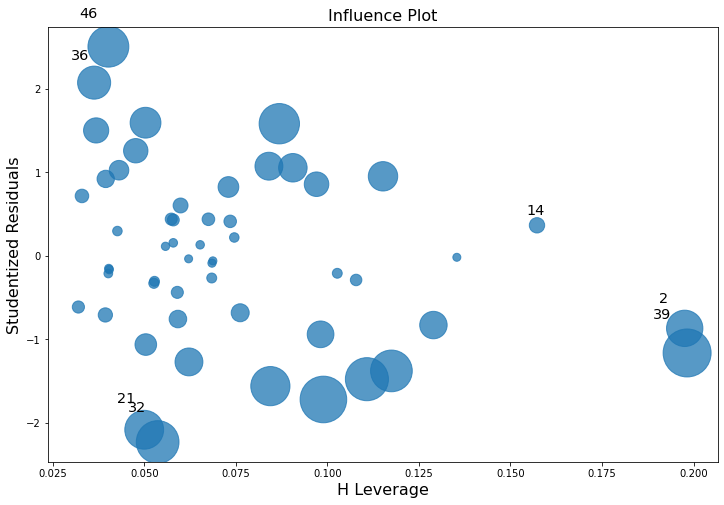

Mean of Residuals: -1.684249447727645e-10


In [368]:
# Model Training

train_X = data_1[['Spring_Summer_Fall', 'Low_Temp', 'Total_Precip']]
train_y = data_1['Bee_Count']
predicted_y = model_2.predict(train_X)

# Plotting the Residuals to check for trend
    
residuals = train_y - predicted_y
    
plt.scatter(predicted_y, residuals, s = 2, c = 'black')
plt.hlines(0, min(predicted_y), max(predicted_y), color = 'red', linestyles = 'dashed')
plt.xlabel('Model Prediction')
plt.ylabel('Residual')
plt.title('Plot of Residual vs Fitted Values')
plt.show()

# Plotting the frequency distribution of the residuals
    
mean, std = norm.fit(residuals)
plt.hist(residuals, bins = 13, edgecolor = 'black', density = True)
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mean, std)
plt.plot(x, p, color = 'black')
title = 'Density Plot of Fit residuals: mu = %.2f, std = %.2f' % (mean, std)
plt.title(title)
plt.show()

# Residuals vs Leverage

fig, ax = plt.subplots(figsize=(12,8))
fig = sm.graphics.influence_plot(model_2, ax=ax, criterion="cooks")
plt.show()
    
print('Mean of Residuals:', residuals.mean())
# print('R-squared for', label, reg_model.score(train_X, train_y)) 

In [369]:
X = data_1[['Spring_Summer_Fall', 'Low_Temp', 'Total_Precip']]
y = data_1['Bee_Count']

X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=0.7,random_state=0)

reg = LinearRegression().fit(X_train, y_train)

#### Evaluation on Training Data

In [370]:
print("R^2:", reg.score(X_train,y_train))
print("Root Mean Squared Error:",sqrt(mean_squared_error(y_train, reg.predict(X_train))))
print("Mean Absolute Error:",mean_absolute_error(y_train, reg.predict(X_train)))

R^2: 0.8799005860960556
Root Mean Squared Error: 8537.527395393276
Mean Absolute Error: 6760.663840027112


#### Evaluation on Testing Data

In [371]:
print("R^2:",reg.score(X_test,y_test))
print("Root Mean Squared Error:",sqrt(
    mean_squared_error(y_test,reg.predict(X_test))))
print("Mean Absolute Error:",mean_absolute_error(
    y_test,reg.predict(X_test)))

R^2: 0.8754302854964625
Root Mean Squared Error: 8886.614762095478
Mean Absolute Error: 7492.139618301906


The model above is a good model for the following reasons - 


- Model performance on the training data and test data are very similar, which is really good, indicated by the similar $R^2$ in each case.


- The $R^2$ of the model which represents goodness of fit, is 88%, indicating the model fits the underlying training data well.


- From an individual feature perspective, the p-values of the t-test of each feature included in the final model is lower than 0.05, indicating the features chosen are statistically significant. This indicates the features themselves have predictive power and explain the predictor variable 'Bee Count' quite well. 


- The individual features having a p-value lower than 0.05 also indicate the features included are not correlated with each other, and there is no bias brought about by collinearity in the final model.


- The p-value of the joint F-test of the model is very low, implying that the variables included in the model have predictive power.


- The residuals are not heteroskedastic, indicating the model results do not have bias in them.


- The Mean Absolute Error (MAE) is small relative to the predictions of bee count.


- From a business perspective, the features chosen do explain the natural phenomenon of changes in bee count with time. 

### Testing the Impact of Different Variables on Bee Count

In [372]:
model_1 = ols('Bee_Count ~ Avg_Temp + Low_Temp + High_Temp', data_1).fit()
model_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              Bee_Count   R-squared:                       0.857
Model:                            OLS   Adj. R-squared:                  0.849
Method:                 Least Squares   F-statistic:                     100.2
Date:                Sat, 15 Apr 2023   Prob (F-statistic):           3.83e-21
Time:                        12:51:35   Log-Likelihood:                -570.48
No. Observations:                  54   AIC:                             1149.
Df Residuals:                      50   BIC:                             1157.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   7328.1818   6386.822      1.147      0.257   -5500.128    2.02e+04
Avg_Temp     432.9949    303.710      1.426      0.160    -177.024    1043.014
Low_Temp     349.3117    325.599      1.073      0.288    -304.672    1003.296
High_Temp    981.8700    345.079      2.845      0.006     288.759    1674.981
==============================================================================
Omnibus:                        0.995   Durbin-Watson:                   1.671
Prob(Omnibus):                  0.608   Jarque-Bera (JB):                1.054
Skew:                          -0.288   Prob(JB):                        0.590
Kurtosis:                       2.629   Cond. No.                         156.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### Hypothesis Testing - Wald Test to check if Temperature impacts Bee Count

In [373]:
hypothesis_a = '(Avg_Temp=0, Low_Temp=0, High_Temp=0)'
print(model_1.wald_test(hypothesis_a))

<F test: F=array([[100.16844777]]), p=3.825602991619636e-21, df_denom=50, df_num=3>


In [374]:
hypothesis_b = '(Low_Temp=0, High_Temp=0)'
print(model_1.wald_test(hypothesis_b))

<F test: F=array([[10.19668982]]), p=0.00019317667951519198, df_denom=50, df_num=2>


In [375]:
hypothesis_c = '(Avg_Temp=0, High_Temp=0)'
print(model_1.wald_test(hypothesis_c))

<F test: F=array([[8.96161789]]), p=0.000471835848369081, df_denom=50, df_num=2>


In [376]:
hypothesis_d = '(Low_Temp=0, Avg_Temp=0)'
print(model_1.wald_test(hypothesis_d))

<F test: F=array([[2.48037136]]), p=0.09395832877329999, df_denom=50, df_num=2>


In [377]:
hypothesis_e = ('Low_Temp=0')
print(model_2.wald_test(hypothesis_e))

<F test: F=array([[55.41173149]]), p=1.2153679884257684e-09, df_denom=50, df_num=1>


If the a model is built with all temperature variables included (model_1), the variable - "High_Temp" is found to be statistically significant, from the p-value of the individual t-tests. If the final model (model_2) is considered, the variable - "Low_Temp" is found to be statistically significant, in the context of the other variables present. Correlation should not be mistaken with causation and a hypothesis test should be performed to see if "High_Temp" actually has predictive power in model_1 and if "Low_Temp" has predictive power in model_2. <br>

Hypothesis a-d for model_1:

There are 3 temperature variables in the dataset. If a Wald Test is performed with all 3 temperature variables, we notice that the p-value of the collective set is very small, indicating that at least one of the 3 temperature variables does have an impact on bee count. If the test is continued with other combinations of 2 variables at a time, we notice that when High Temperature is not present in the null hypothesis, the p-value is very large. This indicates that in this model, the variable "High Temp" has a statistically significant impact on bee count. <br>

Hypothesis e for model_2:

If a Wald Test is performed with just Low_Temp in model_2, we notice a very small p-value. This indicates that the variable Low_Temp has sufficient predictive power for Bee_Count. <br>

Hence, temperature does have sufficient predictive power for Bee Count.

## Model Testing

In [378]:
data_2 = pd.read_excel('/Users/mohammadananjaved/Desktop/MMA860 - Data Acquisition & Management/MMA860_Exam_Data_2024B.xlsx',
                         sheet_name = 'Next_Season')

In [379]:
data_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12 entries, 0 to 11
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Year                  12 non-null     int64  
 1   Month                 12 non-null     object 
 2   Avg_Temp              12 non-null     int64  
 3   Low_Temp              12 non-null     int64  
 4   High_Temp             12 non-null     int64  
 5   Total_Precip          12 non-null     float64
 6   Major_Storm           12 non-null     int64  
 7   Avg_Wind_Speed        12 non-null     float64
 8   Avail_Flower_Species  12 non-null     int64  
dtypes: float64(2), int64(6), object(1)
memory usage: 992.0+ bytes


In [380]:
data_2['Spring_Summer_Fall'] = data_2['Month'].map({'Apr':1, 'Aug':1, 'Jul':1, 'Jun':1, 'Mar':1, 'May':1, 'Oct':1, 'Sep':1,
                                            'Dec':0, 'Feb':0, 'Jan':0, 'Nov':0})

In [381]:
data_2.head()

,Year,Month,Avg_Temp,Low_Temp,High_Temp,Total_Precip,Major_Storm,Avg_Wind_Speed,Avail_Flower_Species,Spring_Summer_Fall
0,2023,Jun,28,15,26,27.2,0,16.3,29,1
1,2023,May,26,10,24,29.9,0,12.0,23,1
2,2023,Apr,10,-2,22,42.8,0,10.7,23,1
3,2023,Mar,4,-12,5,30.0,0,16.1,23,1
4,2023,Feb,8,-22,0,30.8,0,4.3,0,0


In [382]:
X_predict = data_2[['Spring_Summer_Fall', 'Total_Precip', 'Low_Temp']]

In [383]:
X_predict.head()

,Spring_Summer_Fall,Total_Precip,Low_Temp
0,1,27.2,15
1,1,29.9,10
2,1,42.8,-2
3,1,30.0,-12
4,0,30.8,-22


#### Model Prediction

In [384]:
Model_prediction = model_2.predict(X_predict)

In [385]:
Model_prediction

0     56947.135754
1     50872.248020
2     34288.803252
3     27819.339089
4     -4769.136773
5      5445.587591
6      1272.762396
7     13923.683954
8     38438.021911
9     51512.952336
10    56135.662710
11    55120.432374
dtype: float64

#### Checking Confidence Interval Around Model Prediction - For a More Conservative Estimate

In [386]:
Model_prediction_upper_bound = 3.81e+4 + 2.98e+4*data_2['Spring_Summer_Fall'] + 1328.798*data_2['Low_Temp'] - 8.078*data_2['Total_Precip']

In [387]:
Model_prediction_upper_bound

0     87612.2484
1     80946.4478
2     64896.6656
3     51712.0840
4      8617.6416
5     21899.1592
6     12679.1610
7     28627.1604
8     62400.6296
9     82264.7444
10    87591.2456
11    86263.2554
dtype: float64

In [388]:
data_2['Prediction_Upper_Bound'] = Model_prediction_upper_bound
data_2['Prediction'] = Model_prediction

In [389]:
data_2['Swarm'] = [1 if x >= 95000 else 0 for x in data_2['Prediction_Upper_Bound']]

In [390]:
data_2

,Year,Month,Avg_Temp,Low_Temp,High_Temp,Total_Precip,Major_Storm,Avg_Wind_Speed,Avail_Flower_Species,Spring_Summer_Fall,Prediction_Upper_Bound,Prediction,Swarm
0,2023,Jun,28,15,26,27.2,0,16.3,29,1,87612.2484,56947.135754,0
1,2023,May,26,10,24,29.9,0,12.0,23,1,80946.4478,50872.248020,0
2,2023,Apr,10,-2,22,42.8,0,10.7,23,1,64896.6656,34288.803252,0
3,2023,Mar,4,-12,5,30.0,0,16.1,23,1,51712.0840,27819.339089,0
4,2023,Feb,8,-22,0,30.8,0,4.3,0,0,8617.6416,-4769.136773,0
5,2023,Jan,-5,-12,4,31.6,1,15.5,0,0,21899.1592,5445.587591,0
6,2022,Dec,-7,-19,0,21.5,0,13.6,0,0,12679.1610,1272.762396,0
7,2022,Nov,3,-7,13,21.2,1,13.8,0,0,28627.1604,13923.683954,0
8,2022,Oct,25,-4,23,22.8,0,13.7,25,1,62400.6296,38438.021911,0
9,2022,Sep,24,11,28,31.2,2,13.0,27,1,82264.7444,51512.952336,0


Using the predicted values, there is no instance of Bee Count exceeding 95,000. Instead of just looking at a point estimate, if the upper bound of the confidence interval around the estimates is considered (calculated at the 95% significance level), we still do not have a single instance of Bee Count exceeding 95,000. 

Hence, we can conclude with 95% confidence, that swarming is not a possibility, assuming the weather forecast is accurate. 